In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


(…)SUM-EMNLP18-Summary-Data-Original.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

                                             Document  \
0   Prison Link Cymru had 1,099 referrals in 2015-...   
1   Officers searched properties in the Waterfront...   
2   Jordan Hill, Brittany Covington and Tesfaye Co...   
3   The 48-year-old former Arsenal goalkeeper play...   
4   Restoring the function of the organ - which he...   
5   But there certainly should be.\nThese are two ...   
6   Media playback is not supported on this device...   
7   It's no joke. But Kareem Badr says people did ...   
8   Relieved that the giant telecoms company would...   
9   "I'm really looking forward to it - the home o...   
10  The move is in response to an £8m cut in the s...   
11  The leaflets said the patient had been referre...   
12  Emily Thornberry said Labour would not "frustr...   
13  The National League sold the Republic of Irela...   
14  Iwan Wyn Lewis of Penygroes, Gwynedd, had been...   
15  The 33-year-old has featured only twice for th...   
16  Dr Waleed Abdalati told the

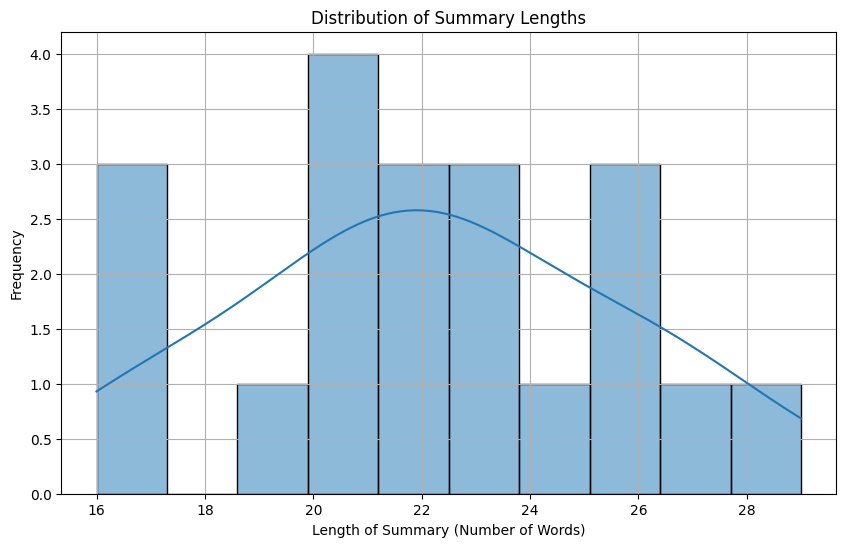

In [ ]:
from transformers import pipeline
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Set up logging for better debugging and monitoring
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the XSum dataset
def load_xsum_dataset():
    logging.info("Loading the XSum dataset...")
    return load_dataset("xsum")

# Initialize the summarization pipeline with a pre-trained model
def initialize_summarizer():
    logging.info("Initializing the summarization model...")
    return pipeline("summarization", model="facebook/bart-large-xsum")

# Function to truncate document to fit model's max sequence length
def truncate_document(document, max_length=1024):
    # Split the document into tokens and truncate
    tokens = document.split()
    truncated_tokens = tokens[:max_length]
    return ' '.join(truncated_tokens)

# Function to summarize a document with error handling and length management
def summarize_document(summarizer, document):
    try:
        # Truncate document to fit model's maximum sequence length
        truncated_document = truncate_document(document)

        # Generate summary with more robust parameters
        summary = summarizer(
            truncated_document,
            max_length=50,
            min_length=25,
            do_sample=False,
            truncation=True
        )
        return summary[0]['summary_text']
    except Exception as e:
        logging.error(f"Error summarizing document: {e}")
        return "Unable to generate summary"

# Function to categorize summaries based on length
def categorize_summary(summary):
    word_count = len(summary.split())
    if word_count < 20:
        return "Short Summary"
    elif 20 <= word_count <= 40:
        return "Medium Summary"
    else:
        return "Long Summary"

# Function to create a DataFrame for better organization
def create_summary_dataframe(summarizer, documents):
    summaries = []

    for document in documents:
        summary = summarize_document(summarizer, document)
        if summary and summary != "Unable to generate summary":
            category = categorize_summary(summary)
            summaries.append({
                "Document": document[:100] + "...",  # Truncate long documents in display
                "Summary": summary,
                "Category": category,
                "Summary Length": len(summary.split())
            })

    return pd.DataFrame(summaries)

# Function to visualize summary lengths
def visualize_summary_lengths(summary_df):
    plt.figure(figsize=(10, 6))
    sns.histplot(summary_df['Summary Length'], bins=10, kde=True)
    plt.title('Distribution of Summary Lengths')
    plt.xlabel('Length of Summary (Number of Words)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.savefig('summary_length_distribution.png')
    plt.show()

# Function to save summaries to a CSV file
def save_summaries_to_csv(summary_df, filename='xsum_summaries.csv'):
    summary_df.to_csv(filename, index=False)
    logging.info(f"Summaries saved to {filename}")

# Main function to execute the summarization process
def main():
    # Load dataset and initialize summarizer
    dataset = load_xsum_dataset()
    summarizer = initialize_summarizer()

    # Number of documents to summarize
    num_docs_to_summarize = 20  # Increased for more robust testing

    logging.info(f"Summarizing the first {num_docs_to_summarize} documents from the XSum dataset...\n")

    # Get the documents to summarize
    documents_to_summarize = [dataset['test'][i]['document'] for i in range(num_docs_to_summarize)]

    # Create DataFrame of summaries
    summary_df = create_summary_dataframe(summarizer, documents_to_summarize)

    # Display the results
    logging.info("Summarization Results:")
    print(summary_df)

    # Visualize summary lengths
    visualize_summary_lengths(summary_df)

    # Save results to CSV file
    save_summaries_to_csv(summary_df)

if __name__ == "__main__":
    main()

In [ ]:
!pip install sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 59.7 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21692 sha256=5b133394ea64d2ccda1ef6733fd0ac46643b7f8c725baf6c6584654d71af6533
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=c7468083eb1f2fab230ca7d49c07355ff8504817271ab59085a8ad8b3eba6017
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Import necessary libraries
from datasets import load_dataset
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
import pandas as pd

# Load the XSum dataset
def load_xsum_dataset():
    print("Loading the XSum dataset...")
    return load_dataset("xsum")

# Function to perform extractive summarization
def extractive_summarization(document, num_sentences=3):
    parser = PlaintextParser.from_string(document, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return ' '.join(str(sentence) for sentence in summary)

# Function to create a DataFrame for summaries
def create_extractive_summary_dataframe(documents):
    summaries = []

    for document in documents:
        summary = extractive_summarization(document)
        summaries.append({
            "Document": document,
            "Extractive Summary": summary,
        })

    return pd.DataFrame(summaries)

# Main function to execute the extractive summarization process
def main():
    # Load dataset
    dataset = load_xsum_dataset()

    # Number of documents to summarize
    num_docs_to_summarize = 10  # Adjust as needed

    print(f"Extractively summarizing the first {num_docs_to_summarize} documents from the XSum dataset...\n")

    # Get documents to summarize
    documents_to_summarize = [dataset['test'][i]['document'] for i in range(num_docs_to_summarize)]

    # Create DataFrame of extractive summaries
    summary_df = create_extractive_summary_dataframe(documents_to_summarize)

    # Display results
    print("Extractive Summarization Results:")
    print(summary_df)

if __name__ == "__main__":
    main()

Loading the XSum dataset...
Extractively summarizing the first 10 documents from the XSum dataset...

Extractive Summarization Results:
                                            Document  \
0  Prison Link Cymru had 1,099 referrals in 2015-...   
1  Officers searched properties in the Waterfront...   
2  Jordan Hill, Brittany Covington and Tesfaye Co...   
3  The 48-year-old former Arsenal goalkeeper play...   
4  Restoring the function of the organ - which he...   
5  But there certainly should be.\nThese are two ...   
6  Media playback is not supported on this device...   
7  It's no joke. But Kareem Badr says people did ...   
8  Relieved that the giant telecoms company would...   
9  "I'm really looking forward to it - the home o...   

                                  Extractive Summary  
0  "There's a desperate need for it, finding suit...  
1  Officers searched properties in the Waterfront...  
2  Jordan Hill, Brittany Covington and Tesfaye Co...  
3  The 48-year-old former A

In [ ]:
from transformers import pipeline
from datasets import load_dataset
import pandas as pd

# Load the XSum dataset
def load_xsum_dataset():
    print("Loading the XSum dataset...")
    return load_dataset("xsum")

# Initialize the summarization pipeline with a pre-trained model
def initialize_summarizer():
    print("Initializing the summarization model...")
    return pipeline("summarization", model="facebook/bart-large-xsum")

# Function to truncate document to fit model's max sequence length
def truncate_document(document, max_length=1024):
    # Split the document into tokens and truncate
    tokens = document.split()
    truncated_tokens = tokens[:max_length]
    return ' '.join(truncated_tokens)

# Function to perform abstractive summarization on a document
def abstractive_summarization(summarizer, document):
    try:
        # Truncate document to fit model's maximum sequence length
        truncated_document = truncate_document(document)

        # Generate summary with more robust parameters
        summary = summarizer(
            truncated_document,
            max_length=50,
            min_length=25,
            do_sample=False,
            truncation=True
        )
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error summarizing document: {e}")
        return "Unable to generate summary"

# Function to create a DataFrame for summaries
def create_abstractive_summary_dataframe(summarizer, documents):
    summaries = []

    for document in documents:
        summary = abstractive_summarization(summarizer, document)
        if summary and summary != "Unable to generate summary":
            summaries.append({
                "Document": document[:300] + "...",  # Truncate long documents in display
                "Abstractive Summary": summary,
            })

    return pd.DataFrame(summaries)

# Main function to execute the abstractive summarization process
def main():
    # Load dataset and initialize summarizer
    dataset = load_xsum_dataset()
    summarizer = initialize_summarizer()

    # Number of documents to summarize
    num_docs_to_summarize = 20  # Increased for more robust testing

    print(f"Abstractively summarizing the first {num_docs_to_summarize} documents from the XSum dataset...\n")

    # Get documents to summarize
    documents_to_summarize = [dataset['test'][i]['document'] for i in range(num_docs_to_summarize)]

    # Create DataFrame of abstractive summaries
    summary_df = create_abstractive_summary_dataframe(summarizer, documents_to_summarize)

    # Display results
    print("Abstractive Summarization Results:")
    print(summary_df)

if __name__ == "__main__":
    main()

Loading the XSum dataset...
Initializing the summarization model...
Abstractively summarizing the first 20 documents from the XSum dataset...

Abstractive Summarization Results:
                                             Document  \
0   Prison Link Cymru had 1,099 referrals in 2015-...   
1   Officers searched properties in the Waterfront...   
2   Jordan Hill, Brittany Covington and Tesfaye Co...   
3   The 48-year-old former Arsenal goalkeeper play...   
4   Restoring the function of the organ - which he...   
5   But there certainly should be.\nThese are two ...   
6   Media playback is not supported on this device...   
7   It's no joke. But Kareem Badr says people did ...   
8   Relieved that the giant telecoms company would...   
9   "I'm really looking forward to it - the home o...   
10  The move is in response to an £8m cut in the s...   
11  The leaflets said the patient had been referre...   
12  Emily Thornberry said Labour would not "frustr...   
13  The National League 

In [ ]:
pip install rouge

In [ ]:
from rouge import Rouge

# Function to evaluate summaries with Rouge
def evaluate_summary(reference, generated):
    rouge = Rouge()
    scores = rouge.get_scores(generated, reference, avg=True)
    return scores

# Unified function for both summarization methods
def perform_and_evaluate_summarization(documents, abstractive_summarizer):
    results = []

    for doc in documents:
        # Abstractive Summarization
        abs_summary = abstractive_summarization(abstractive_summarizer, doc)

        # Extractive Summarization
        ext_summary = extractive_summarization(doc)

        # Evaluation Metrics
        if abs_summary and ext_summary:
            rouge_scores = evaluate_summary(doc, abs_summary)
            results.append({
                "Document": doc,
                "Abstractive Summary": abs_summary,
                "Extractive Summary": ext_summary,
                "Rouge Scores": rouge_scores
            })

    return pd.DataFrame(results)

# Unified Main Function
def main():
    # Load dataset and initialize summarizer
    dataset = load_xsum_dataset()
    summarizer = initialize_summarizer()

    num_docs_to_summarize = 10
    documents_to_summarize = [dataset['test'][i]['document'] for i in range(num_docs_to_summarize)]

    summary_results = perform_and_evaluate_summarization(documents_to_summarize, summarizer)

    # Save results
    summary_results.to_csv("unified_summaries_with_metrics.csv", index=False)
    print("Summarization completed and saved!")

if __name__ == "__main__":
    main()


Loading the XSum dataset...
Initializing the summarization model...
Summarization completed and saved!


In [ ]:
pip install streamlit transformers datasets wordcloud matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


Loading the XSum dataset...
Initializing the summarization model...


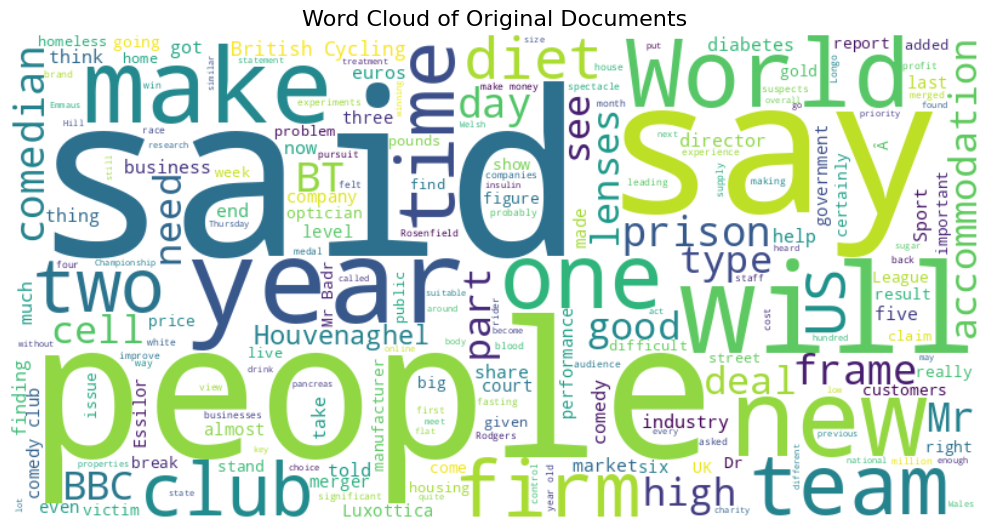

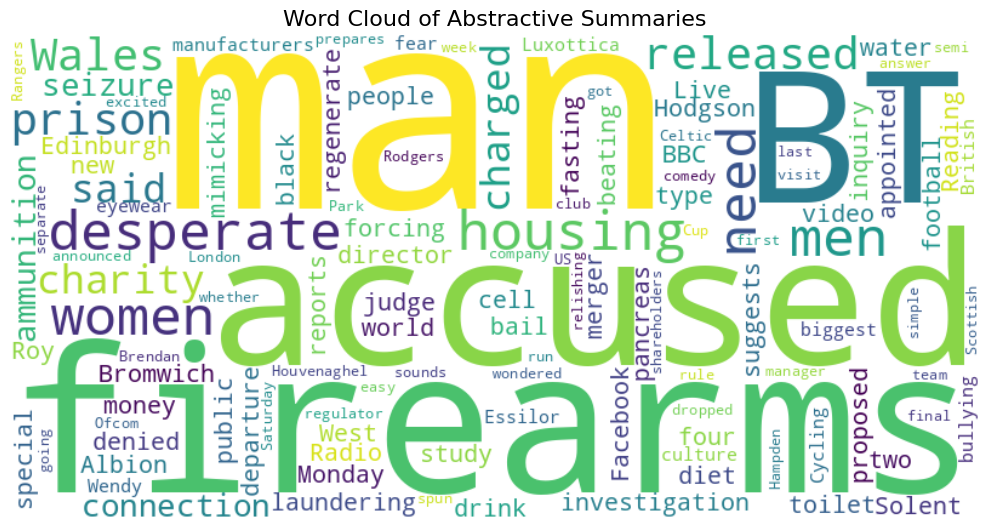

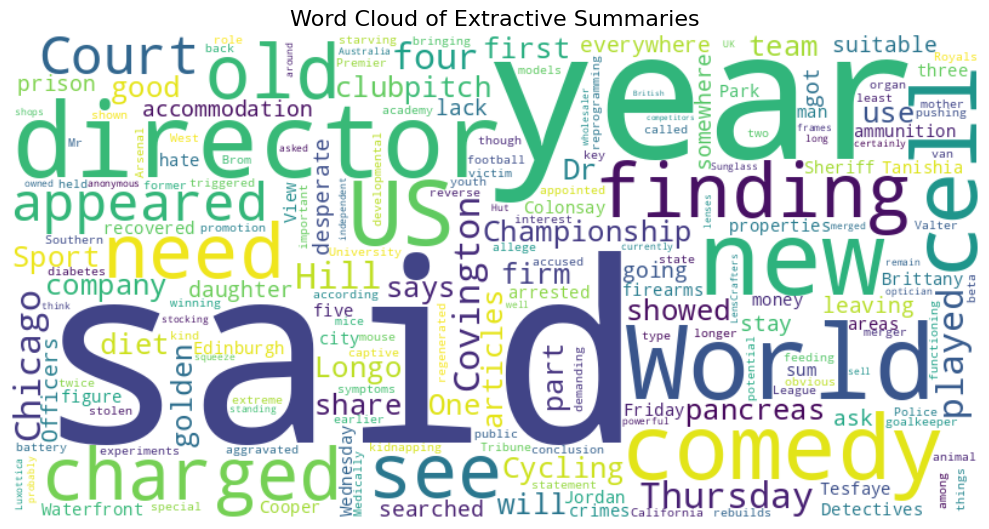

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import logging
import pandas as pd

# Unified function to generate word clouds
def generate_wordcloud(text, title="Word Cloud", save_as=None):
    """
    Generates and displays a word cloud from a given text.

    Parameters:
    - text (str): The input text for generating the word cloud.
    - title (str): Title of the plot.
    - save_as (str): Optional file path to save the word cloud image.
    """
    if not text.strip():
        logging.error("The input text for the word cloud is empty. Please check the source.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="viridis",
        max_words=200
    ).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.tight_layout()

    # Save the word cloud image if a path is provided
    if save_as:
        wordcloud.to_file(save_as)
        logging.info(f"Word cloud saved to {save_as}")

    plt.show()

# Unified main function for summarization and word clouds
def main():
    # Set up logging for debugging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    # Load dataset and initialize summarizer
    dataset = load_xsum_dataset()
    summarizer = initialize_summarizer()

    # Number of documents to summarize
    num_docs_to_summarize = 10
    logging.info(f"Summarizing the first {num_docs_to_summarize} documents from the XSum dataset...")

    # Fetch documents to summarize
    documents_to_summarize = [dataset['test'][i]['document'] for i in range(num_docs_to_summarize)]

    # Skip empty documents
    documents_to_summarize = [doc for doc in documents_to_summarize if doc.strip()]
    if not documents_to_summarize:
        logging.error("No valid documents found in the dataset.")
        return

    # Generate abstractive summaries
    logging.info("Generating abstractive summaries...")
    abstractive_df = create_summary_dataframe(summarizer, documents_to_summarize)

    # Generate extractive summaries
    logging.info("Generating extractive summaries...")
    extractive_df = create_extractive_summary_dataframe(documents_to_summarize)

    # Merge summaries into one DataFrame for comparison
    logging.info("Combining abstractive and extractive summaries...")
    combined_df = pd.concat([
        abstractive_df.rename(columns={"Summary": "Abstractive Summary"}),
        extractive_df.rename(columns={"Extractive Summary": "Summary"})
    ], axis=1)

    # Save combined summaries to a CSV file
    combined_df.to_csv("combined_summaries.csv", index=False)
    logging.info("Summaries saved to combined_summaries.csv")

    # Generate word clouds
    logging.info("Generating word clouds...")
    generate_wordcloud(" ".join(documents_to_summarize), title="Word Cloud of Original Documents", save_as="original_documents_wordcloud.png")
    generate_wordcloud(" ".join(abstractive_df['Summary']), title="Word Cloud of Abstractive Summaries", save_as="abstractive_summaries_wordcloud.png")
    generate_wordcloud(" ".join(extractive_df['Extractive Summary']), title="Word Cloud of Extractive Summaries", save_as="extractive_summaries_wordcloud.png")

    # Display results
    logging.info("Summarization and word cloud generation completed successfully.")

if __name__ == "__main__":
    main()
